# Bitcoin OTC Signed Network — EDA

 **Exploratory Data Analysis (EDA)** of the Bitcoin OTC trust network (signed, weighted, directed, temporal).  

## 1. Setup

In [ ]:
# Install dependencies if needed
# %pip install networkx python-louvain pandas matplotlib

import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# IMPORTANT: charts must use matplotlib and single plots (no subplots), and no explicit colors.
plt.rcParams.update({"figure.facecolor": "white"})  # for clean export

# Set the path to your CSV file 
DATA_PATH = "data/soc-sign-bitcoinotc.csv"

assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}. Please set DATA_PATH to your local file."
print('Using data at:', os.path.abspath(DATA_PATH))

Using data at: /Users/katyatkachuk/ITU/Network Analysis/NA Project/data/soc-sign-bitcoinotc.csv


## 2. Load Data

In [7]:
# The original file has no header row. We assign column names accordingly:
# SOURCE, TARGET, RATING, TIME (Unix epoch seconds)
col_names = ["source", "target", "rating", "time"]
df = pd.read_csv(DATA_PATH, names=col_names)

display(df.head(10))  # preview
print('\nShape:', df.shape)
print('Min/Max rating:', df["rating"].min(), df["rating"].max())
print('Time range (epoch):', int(df["time"].min()), '→', int(df["time"].max()))

,source,target,rating,time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
5,13,10,8,1.289254e+09
6,7,5,1,1.289363e+09
7,2,21,5,1.289371e+09
8,2,20,5,1.289371e+09
9,21,2,5,1.289381e+09



Shape: (35592, 4)
Min/Max rating: -10 10
Time range (epoch): 1289241911 → 1453684323


### Conclusions (Load Data)
- The dataset includes trust interactions between users of the Bitcoin OTC market.
- Ratings range from –10 (strong distrust) to +10 (strong trust).
- Data covers multiple years (based on timestamps) → temporal analysis is meaningful.

## 3. Build Directed Graph with Attributes

In [8]:
G = nx.from_pandas_edgelist(
    df, source="source", target="target",
    edge_attr=["rating", "time"],
    create_using=nx.DiGraph()
)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Positive/negative edges
pos_edges = sum(1 for _,_,d in G.edges(data=True) if d["rating"] > 0)
neg_edges = sum(1 for _,_,d in G.edges(data=True) if d["rating"] < 0)
pct_pos = pos_edges / G.number_of_edges() * 100 if G.number_of_edges() else float('nan')

print("Positive edges:", pos_edges)
print("Negative edges:", neg_edges)
print("Percentage positive:", round(pct_pos, 2), "%")

Nodes: 5881
Edges: 35592
Positive edges: 32029
Negative edges: 3563
Percentage positive: 89.99 %


### Conclusions (Graph construction)
- ~90% of edges are positive → trust dominates interactions.
- Signed edges allow differentiation between cooperative and conflictual behavior.

In [9]:
# Computes the degree for every node in the directed network
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]


## 4. Degree Distributions

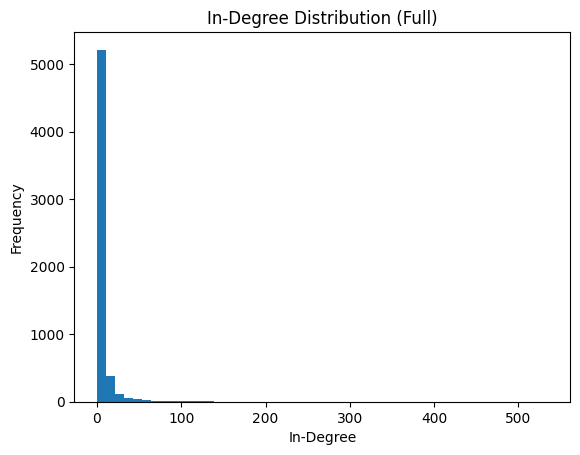

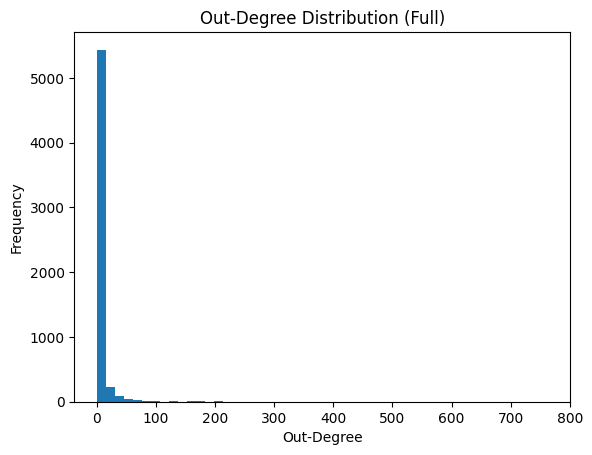

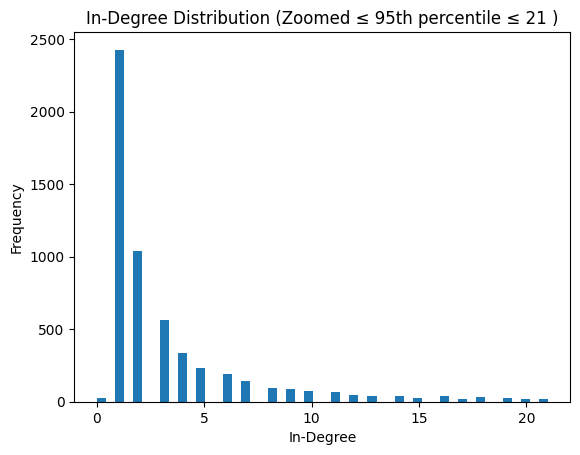

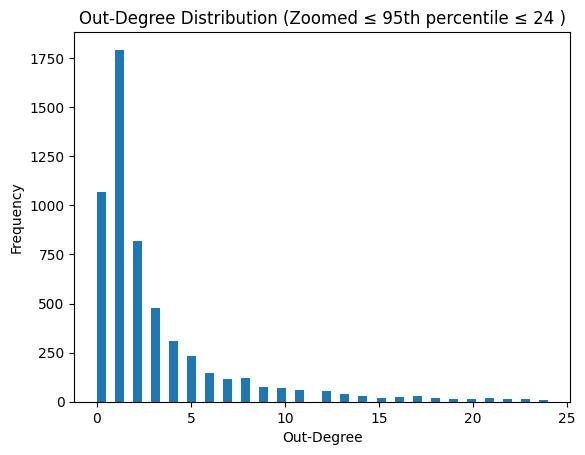

95th percentile In-Degree threshold: 21.0
95th percentile Out-Degree threshold: 24.0


In [10]:
# Full In-Degree
plt.figure()
plt.hist(in_degrees, bins=50)
plt.title("In-Degree Distribution (Full)")
plt.xlabel("In-Degree")
plt.ylabel("Frequency")
plt.show()

# Full Out-Degree
plt.figure()
plt.hist(out_degrees, bins=50)
plt.title("Out-Degree Distribution (Full)")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")
plt.show()

# Zoomed — remove top 5% outliers
threshold_in = np.percentile(in_degrees, 95)
threshold_out = np.percentile(out_degrees, 95)

in_degrees_zoom = [d for d in in_degrees if d <= threshold_in]
out_degrees_zoom = [d for d in out_degrees if d <= threshold_out]

# Zoomed In-Degree
plt.figure()
plt.hist(in_degrees_zoom, bins=50)
plt.title(f"In-Degree Distribution (Zoomed ≤ 95th percentile ≤ {int(threshold_in)} )")
plt.xlabel("In-Degree")
plt.ylabel("Frequency")
plt.show()

# Zoomed Out-Degree
plt.figure()
plt.hist(out_degrees_zoom, bins=50)
plt.title(f"Out-Degree Distribution (Zoomed ≤ 95th percentile ≤ {int(threshold_out)} )")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")
plt.show()

print("95th percentile In-Degree threshold:", threshold_in)
print("95th percentile Out-Degree threshold:", threshold_out)


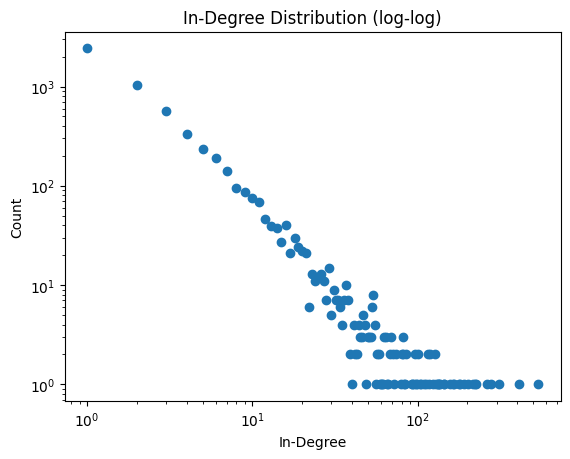

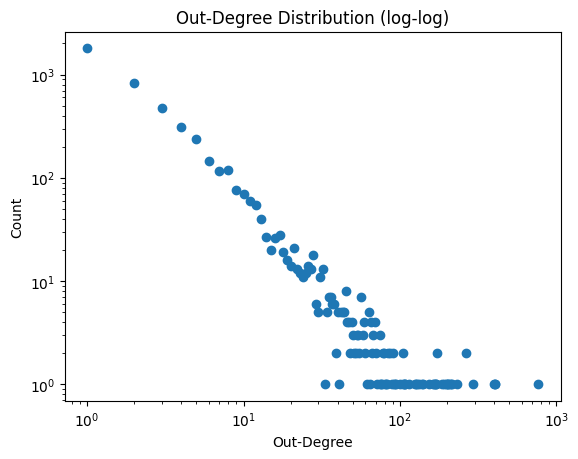

In [11]:
# Log-log view for heavy-tailed behavior (counts aggregated by degree)
def degree_counts(deg_list):
    counts = {}
    for k in deg_list:
        counts[k] = counts.get(k, 0) + 1
    xs = np.array(sorted([k for k in counts.keys() if k>0], key=int))
    ys = np.array([counts[k] for k in xs])
    return xs, ys

xs_in, ys_in = degree_counts(in_degrees)
xs_out, ys_out = degree_counts(out_degrees)

plt.figure()
plt.loglog(xs_in, ys_in, marker='o', linestyle='None')
plt.title("In-Degree Distribution (log-log)")
plt.xlabel("In-Degree")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.loglog(xs_out, ys_out, marker='o', linestyle='None')
plt.title("Out-Degree Distribution (log-log)")
plt.xlabel("Out-Degree")
plt.ylabel("Count")
plt.show()

### Conclusions (Degree distributions)
- Most users give/receive very few ratings → long-tail distribution.
- A small number of hubs receive disproportionately high trust (in-degree up to ~535) and/or give many ratings.
- Log-log plots suggest scale-free structure → typical for social networks.

## 5. Rating Distribution

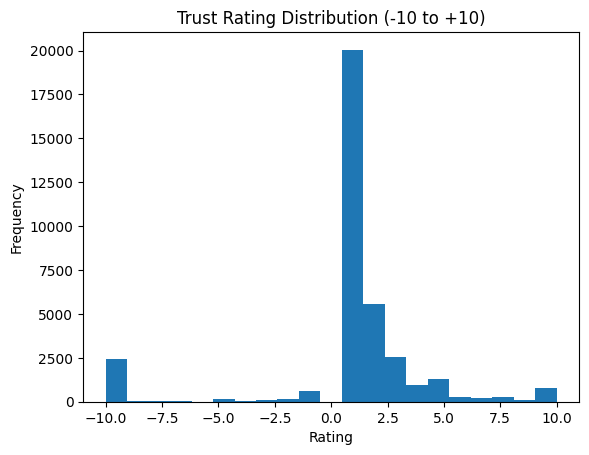

In [12]:
plt.figure()
plt.hist(df["rating"], bins=21)
plt.title("Trust Rating Distribution (-10 to +10)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

### Conclusions (Ratings)
- Ratings are strongly skewed toward positive values.
- Distrust exists but is relatively rare (~10%) → platform is generally cooperative.

## 6. Connectivity

In [15]:
num_scc = nx.number_strongly_connected_components(G)
num_wcc = nx.number_weakly_connected_components(G)
largest_wcc_nodes = max(nx.weakly_connected_components(G), key=len)
largest_wcc = G.subgraph(largest_wcc_nodes)
print("Strongly connected components:", num_scc)
print("Weakly connected components:", num_wcc)
print("Largest WCC size:", len(largest_wcc_nodes))

Strongly connected components: 1144
Weakly connected components: 4
Largest WCC size: 5875


In [16]:
# Diameter on undirected version of the largest WCC (can be heavy but acceptable for this graph)
diam = nx.diameter(largest_wcc.to_undirected())
print("Approximate diameter (largest WCC, undirected):", diam)

Approximate diameter (largest WCC, undirected): 9


### Conclusions (Connectivity)
- The network has 1144 SCCs but only 4 WCCs, so it is nearly fully connected when ignoring direction.
- The largest WCC includes 5875 of 5881 nodes → almost all users are part of one trust ecosystem.
- Diameter of WCC ≈ 9 → small-world property: trust can propagate very quickly.

## 7. Top Nodes (Hubs)

In [17]:
top_in = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
top_out = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 by in-degree:", top_in)
print("Top 10 by out-degree:", top_out)

# Convert to DataFrame for nicer view
df_top_in = pd.DataFrame(top_in, columns=["node", "in_degree"])
df_top_out = pd.DataFrame(top_out, columns=["node", "out_degree"])
display(df_top_in)
display(df_top_out)

Top 10 by in-degree: [(35, 535), (2642, 412), (1810, 311), (2028, 279), (905, 264), (1, 226), (4172, 222), (7, 216), (4197, 203), (13, 191)]
Top 10 by out-degree: [(35, 763), (2642, 406), (1810, 404), (2125, 397), (2028, 293), (905, 264), (4172, 264), (7, 232), (1, 215), (3129, 212)]


,node,in_degree
0,35,535
1,2642,412
2,1810,311
3,2028,279
4,905,264
5,1,226
6,4172,222
7,7,216
8,4197,203
9,13,191


,node,out_degree
0,35,763
1,2642,406
2,1810,404
3,2125,397
4,2028,293
5,905,264
6,4172,264
7,7,232
8,1,215
9,3129,212


### Conclusions (Top nodes)
- Node 35 is the most central by both in- and out-degree → likely a highly reputable and active trader.
- A few users form a highly trusted “elite” in the marketplace.
- Power concentration suggests reputation inequality.

## 8. Positive vs Negative Subgraphs

In [18]:
# Build positive-only and negative-only graphs
G_pos = nx.DiGraph()
G_neg = nx.DiGraph()
for u, v, d in G.edges(data=True):
    if d["rating"] > 0:
        G_pos.add_edge(u, v, **d)
    elif d["rating"] < 0:
        G_neg.add_edge(u, v, **d)

print("Positive subgraph - nodes:", G_pos.number_of_nodes(), "edges:", G_pos.number_of_edges())
print("Negative subgraph - nodes:", G_neg.number_of_nodes(), "edges:", G_neg.number_of_edges())

# Largest components sizes
lcc_pos = len(max(nx.weakly_connected_components(G_pos), key=len)) if G_pos.number_of_nodes() else 0
lcc_neg = len(max(nx.weakly_connected_components(G_neg), key=len)) if G_neg.number_of_nodes() else 0
print("Largest WCC (positive):", lcc_pos)
print("Largest WCC (negative):", lcc_neg)

Positive subgraph - nodes: 5573 edges: 32029
Negative subgraph - nodes: 1606 edges: 3563
Largest WCC (positive): 5551
Largest WCC (negative): 1455


### Conclusions (Positive vs Negative)
- Positive-only network remains highly connected.
- Negative-only network is fragmented → distrust does not form stable communities.
- This supports the hypothesis that distrust may be directed between groups, not inside them.

## 9. Temporal Overview

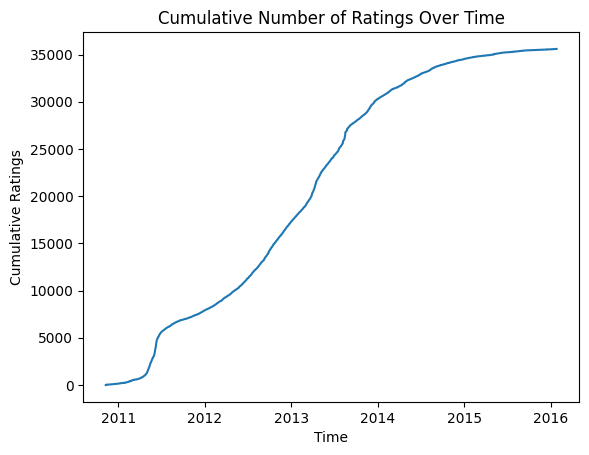

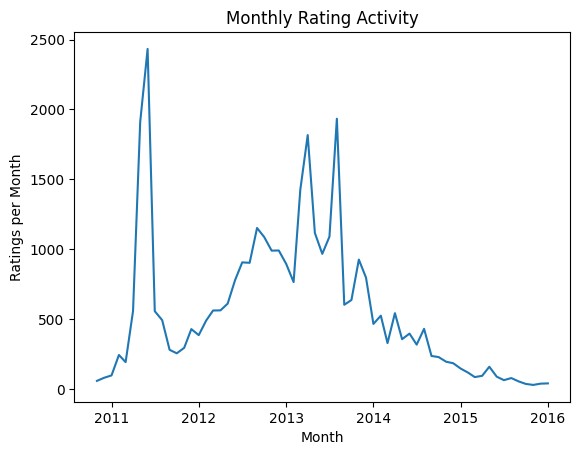

In [19]:
# Convert epoch to datetime for simple time plots
df['datetime'] = pd.to_datetime(df['time'], unit='s')
df_sorted = df.sort_values('datetime').copy()

# Cumulative edges over time
df_sorted['cum_edges'] = range(1, len(df_sorted)+1)
plt.figure()
plt.plot(df_sorted['datetime'], df_sorted['cum_edges'])
plt.title("Cumulative Number of Ratings Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative Ratings")
plt.show()

# Monthly activity (counts per month)
monthly = df_sorted.resample('MS', on='datetime').size()
plt.figure()
plt.plot(monthly.index, monthly.values)
plt.title("Monthly Rating Activity")
plt.xlabel("Month")
plt.ylabel("Ratings per Month")
plt.show()

### Conclusions (Temporal)
- Number of ratings grows over time → increasing platform adoption.
- Monthly activity fluctuates → potential behavioral or market effects worth future analysis.

## 10. (Optional) Save Figures

In [13]:
# Re-run or adapt specific plots to save them as files for your slides.
# Example for saving: (uncomment and rerun the corresponding plot)
# plt.figure()
# plt.hist(in_degrees, bins=50)
# plt.title("In-Degree Distribution")
# plt.xlabel("In-Degree")
# plt.ylabel("Frequency")
# plt.savefig("in_degree_distribution.png", dpi=200, bbox_inches="tight")
# print("Saved in_degree_distribution.png")

## Trust vs. Distrust relationships

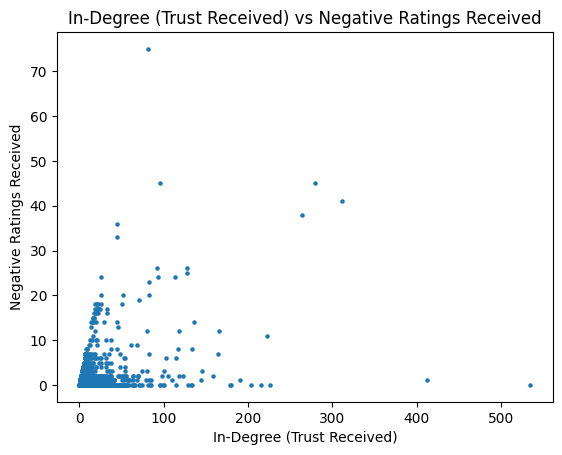

,node,negative_in_degree
0,3744,75
1,1383,45
2,2028,45
3,1810,41
4,905,38
5,2498,36
6,2017,33
7,832,26
8,3897,26
9,2045,25


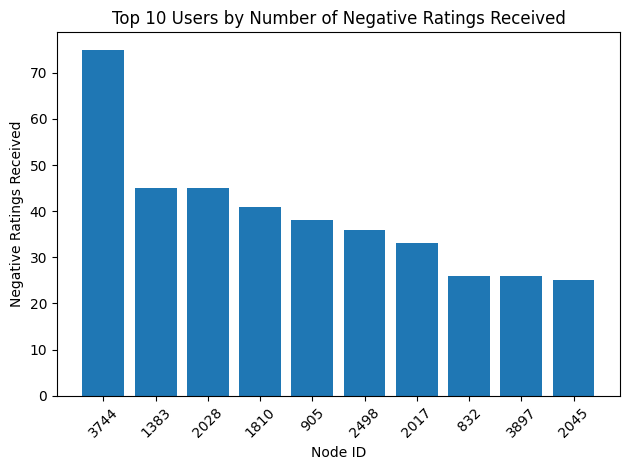

Users who give at least one negative rating: 737
Median in-degree (all users): 2.00
Median in-degree (negative raters): 11.00
Mean in-degree (all users): 6.05
Mean in-degree (negative raters): 24.40


/var/folders/nf/3q47hb5d1zd32308427gnl780000gn/T/ipykernel_43200/2922742703.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([in_deg_all, in_deg_neg_raters], labels=["All users", "Negative raters"])


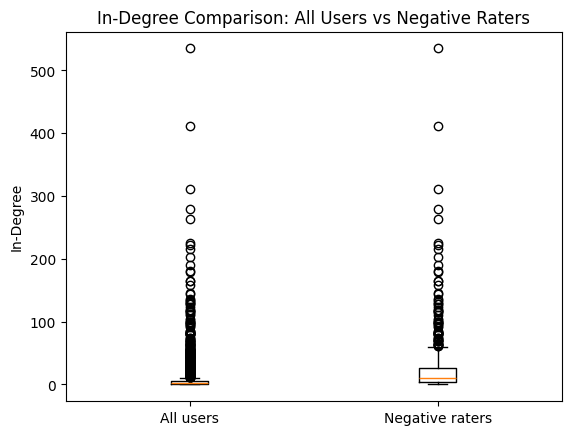

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Ensure degree vectors/maps
in_degree_map = dict(G.in_degree())
out_degree_map = dict(G.out_degree())

# Negative ratings received per node (negative in-degree)
neg_in_counts = []
for n in G.nodes():
    cnt = 0
    for _, _, d in G.in_edges(n, data=True):
        if d.get("rating", 0) < 0:
            cnt += 1
    neg_in_counts.append((n, cnt))

# Negative ratings given per node (negative out-degree)
neg_out_counts = []
for n in G.nodes():
    cnt = 0
    for _, _, d in G.out_edges(n, data=True):
        if d.get("rating", 0) < 0:
            cnt += 1
    neg_out_counts.append((n, cnt))

# --- Scatter: in-degree (trust) vs negative ratings received ---
x_in = [in_degree_map.get(n, 0) for n, _ in neg_in_counts]
y_neg_received = [c for _, c in neg_in_counts]

plt.figure()
plt.scatter(x_in, y_neg_received, s=5)
plt.title("In-Degree (Trust Received) vs Negative Ratings Received")
plt.xlabel("In-Degree (Trust Received)")
plt.ylabel("Negative Ratings Received")
plt.show()

# --- Bar chart: top 10 negative receivers ---
top_neg_recv = sorted(neg_in_counts, key=lambda t: t[1], reverse=True)[:10]
df_top_neg_recv = pd.DataFrame(top_neg_recv, columns=["node", "negative_in_degree"])
display(df_top_neg_recv)

plt.figure()
plt.bar(range(len(df_top_neg_recv)), df_top_neg_recv["negative_in_degree"].values)
plt.xticks(range(len(df_top_neg_recv)), df_top_neg_recv["node"].astype(str).values, rotation=45)
plt.title("Top 10 Users by Number of Negative Ratings Received")
plt.xlabel("Node ID")
plt.ylabel("Negative Ratings Received")
plt.tight_layout()
plt.show()

# --- Are negative raters 'outsiders'? ---
# Compare in-degree distribution of negative raters vs all users
neg_raters = [n for n, c in neg_out_counts if c > 0]
in_deg_neg_raters = [in_degree_map.get(n, 0) for n in neg_raters]
in_deg_all = list(in_degree_map.values())

median_neg_rater = np.median(in_deg_neg_raters) if len(in_deg_neg_raters) else 0
median_all = np.median(in_deg_all) if len(in_deg_all) else 0
mean_neg_rater = np.mean(in_deg_neg_raters) if len(in_deg_neg_raters) else 0
mean_all = np.mean(in_deg_all) if len(in_deg_all) else 0

print(f"Users who give at least one negative rating: {len(neg_raters)}")
print(f"Median in-degree (all users): {median_all:.2f}")
print(f"Median in-degree (negative raters): {median_neg_rater:.2f}")
print(f"Mean in-degree (all users): {mean_all:.2f}")
print(f"Mean in-degree (negative raters): {mean_neg_rater:.2f}")

# Optional: quick boxplot comparison (single figure, simple)
plt.figure()
plt.boxplot([in_deg_all, in_deg_neg_raters], labels=["All users", "Negative raters"])
plt.title("In-Degree Comparison: All Users vs Negative Raters")
plt.ylabel("In-Degree")
plt.show()


Distrust scales with visibility — the users who are most trusted are also the most criticized.

## Reputation Inequality (Gini + Lorenz)

Gini coefficient (In-Degree / received trust): 0.6856


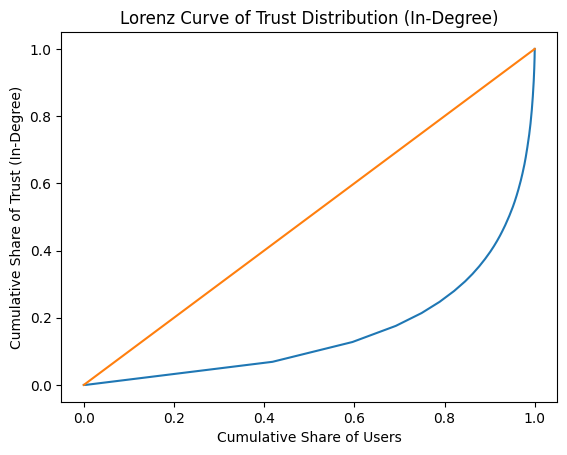

Interpretation: Trust is highly unequal.


In [20]:
import numpy as np
import matplotlib.pyplot as plt

in_degrees = [G.in_degree(n) for n in G.nodes()]

def gini(array_like):
    x = np.array(array_like, dtype=float).flatten()
    # Degrees are non-negative; still guard against weird cases
    if np.min(x) < 0:
        x = x - np.min(x)
    if np.all(x == 0):
        return 0.0
    x = np.sort(x)
    n = x.size
    cumx = np.cumsum(x)
    # Relative mean absolute difference formula
    g = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return float(g)

gini_in = gini(in_degrees)
print(f"Gini coefficient (In-Degree / received trust): {gini_in:.4f}")

# Lorenz curve
sorted_in = np.sort(np.array(in_degrees, dtype=float))
if np.sum(sorted_in) == 0:
    lorenz = np.zeros(sorted_in.size + 1)
else:
    lorenz = np.cumsum(sorted_in) / np.sum(sorted_in)
lorenz = np.insert(lorenz, 0, 0.0)  # start at (0,0)
x_lorenz = np.linspace(0, 1, lorenz.size)

plt.figure()
plt.plot(x_lorenz, lorenz)
plt.plot([0, 1], [0, 1])  # line of equality
plt.title("Lorenz Curve of Trust Distribution (In-Degree)")
plt.xlabel("Cumulative Share of Users")
plt.ylabel("Cumulative Share of Trust (In-Degree)")
plt.show()

# Optional: print an interpretation hint
if gini_in >= 0.8:
    print("Interpretation: Trust distribution is extremely unequal (elite hubs).")
elif gini_in >= 0.6:
    print("Interpretation: Trust is highly unequal.")
else:
    print("Interpretation: Trust inequality is moderate/low.")



Trust in the Bitcoin OTC network is highly unequal — only a tiny elite group receives most of the trust.

In [ ]:
# !pip install python-louvain --quiet # if not installed


/Users/katyatkachuk/ITU/Network Analysis/Project/venv/bin/pip: line 2: /Users/katyatkachuk/ITU/Network Analysis/NA Project/venv/bin/python: No such file or directory
/Users/katyatkachuk/ITU/Network Analysis/Project/venv/bin/pip: line 2: exec: /Users/katyatkachuk/ITU/Network Analysis/NA Project/venv/bin/python: cannot execute: No such file or directory


## Community detection on the positive network (undirected largest component)

Detected communities (Louvain on positive LCC): 31


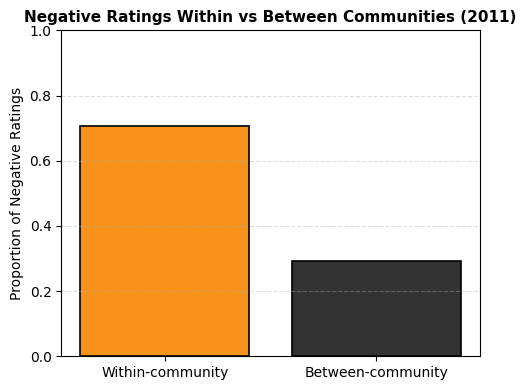

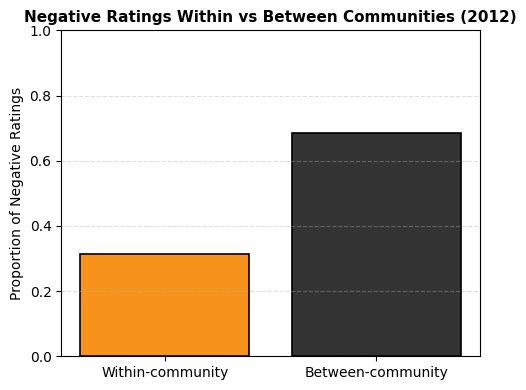

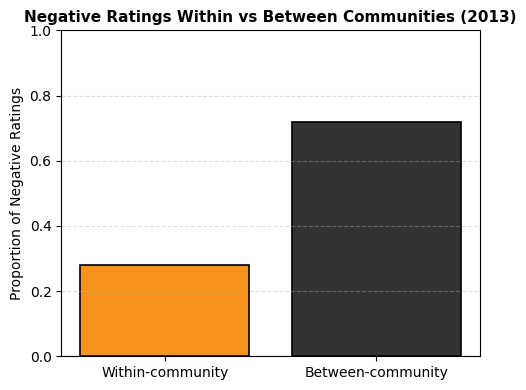

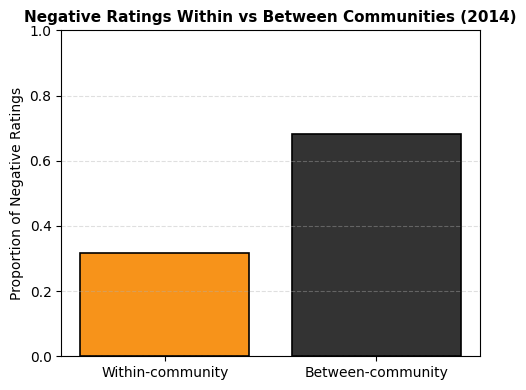

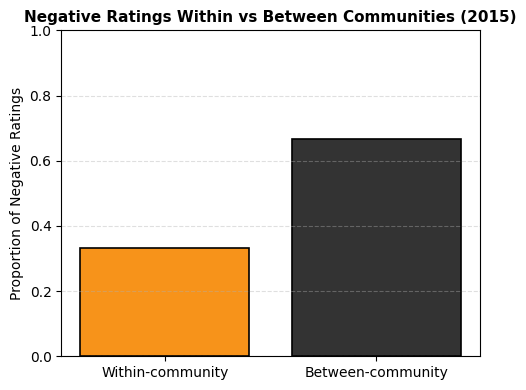

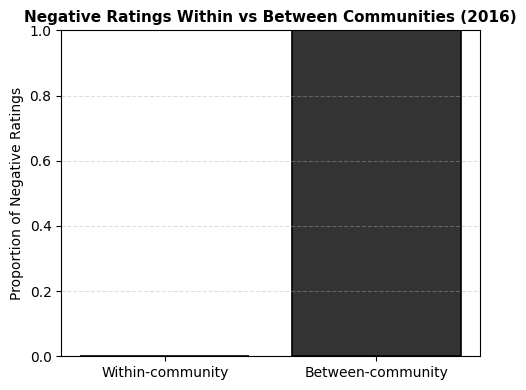

,within,between
2011,0.707143,0.292857
2012,0.313830,0.686170
2013,0.280374,0.719626
2014,0.317073,0.682927
2015,0.333333,0.666667
2016,0.000000,1.000000


In [ ]:
import community as community_louvain
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Build positive-only graph if not already present
try:
    G_pos
except NameError:
    G_pos = nx.DiGraph()
    for u, v, d in G.edges(data=True):
        if d.get("rating", 0) > 0:
            G_pos.add_edge(u, v, **d)

# Largest weakly-connected component (positive graph)
if G_pos.number_of_nodes() == 0:
    raise ValueError("Positive subgraph is empty.")
largest_pos_nodes = max(nx.weakly_connected_components(G_pos), key=len)
G_pos_lcc = G_pos.subgraph(largest_pos_nodes).copy()

# Louvain on UNDIRECTED version of the positive LCC
part = community_louvain.best_partition(G_pos_lcc.to_undirected())
num_comms = len(set(part.values()))
print("Detected communities (Louvain on positive LCC):", num_comms)

# Map every node in the full graph to a community id (unknown nodes get -1)
comm_map = {n: part.get(n, -1) for n in G.nodes()}

# --- Yearly proportions of negative edges within vs between communities ---
if "datetime" not in df.columns:
    df["datetime"] = pd.to_datetime(df["time"], unit="s")
df["year"] = df["datetime"].dt.year

yearly_ratios = {}
for year, dyear in df.groupby("year"):
    dneg = dyear[dyear["rating"] < 0]
    if dneg.empty:
        continue
    within = between = 0
    for _, row in dneg.iterrows():
        cu = comm_map.get(row["source"], -1)
        cv = comm_map.get(row["target"], -1)
        if cu == -1 or cv == -1:
            continue
        if cu == cv:
            within += 1
        else:
            between += 1
    tot = within + between
    if tot == 0:
        continue
    yearly_ratios[year] = {"within": within / tot, "between": between / tot}

# --- Simple bars for each year + save to figures/ ---
Path("figures").mkdir(exist_ok=True)

BTC_ORANGE = "#f7931a"
DARK_GRAY = "#333333"

for year in sorted(yearly_ratios.keys()):
    vals = yearly_ratios[year]
    plt.figure(figsize=(5, 4))
    plt.bar(
        ["Within-community", "Between-community"],
        [vals["within"], vals["between"]],
        color=[BTC_ORANGE, DARK_GRAY],
        edgecolor="black",
        linewidth=1.2
    )
    plt.ylim(0, 1)
    plt.title(f"Negative Ratings Within vs Between Communities ({year})", fontsize=11, fontweight="bold")
    plt.ylabel("Proportion of Negative Ratings")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"figures/negative_within_between_{year}.png", bbox_inches="tight", dpi=200)
    plt.show()

# Quick table preview
pd.DataFrame(yearly_ratios).T.sort_index()


## 11. Save all notebook figures to disk 

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)

def save_fig(fig, filename, tight=True):
    if tight:
        fig.tight_layout()
    out_path = output_dir / filename
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved {out_path}")

# Recompute derived data so the cell is standalone
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

threshold_in = float(np.percentile(in_degrees, 95)) if in_degrees else 0.0
threshold_out = float(np.percentile(out_degrees, 95)) if out_degrees else 0.0
in_degrees_zoom = [d for d in in_degrees if d <= threshold_in]
out_degrees_zoom = [d for d in out_degrees if d <= threshold_out]

# Degree distributions
fig, ax = plt.subplots()
ax.hist(in_degrees, bins=50)
ax.set_title("In-Degree Distribution (Full)")
ax.set_xlabel("In-Degree")
ax.set_ylabel("Frequency")
save_fig(fig, "01_in_degree_distribution_full.png")

fig, ax = plt.subplots()
ax.hist(out_degrees, bins=50)
ax.set_title("Out-Degree Distribution (Full)")
ax.set_xlabel("Out-Degree")
ax.set_ylabel("Frequency")
save_fig(fig, "02_out_degree_distribution_full.png")

fig, ax = plt.subplots()
ax.hist(in_degrees_zoom, bins=50)
ax.set_title(f"In-Degree Distribution (Zoomed <= 95th percentile <= {int(threshold_in)})")
ax.set_xlabel("In-Degree")
ax.set_ylabel("Frequency")
save_fig(fig, "03_in_degree_distribution_zoomed.png")

fig, ax = plt.subplots()
ax.hist(out_degrees_zoom, bins=50)
ax.set_title(f"Out-Degree Distribution (Zoomed <= 95th percentile <= {int(threshold_out)})")
ax.set_xlabel("Out-Degree")
ax.set_ylabel("Frequency")
save_fig(fig, "04_out_degree_distribution_zoomed.png")

def degree_counts(values):
    counts = {}
    for v in values:
        counts[v] = counts.get(v, 0) + 1
    xs = np.array(sorted([k for k in counts.keys() if k > 0], key=int))
    ys = np.array([counts[k] for k in xs])
    return xs, ys

xs_in, ys_in = degree_counts(in_degrees)
if xs_in.size:
    fig, ax = plt.subplots()
    ax.loglog(xs_in, ys_in, marker='o', linestyle='None')
    ax.set_title("In-Degree Distribution (log-log)")
    ax.set_xlabel("In-Degree")
    ax.set_ylabel("Count")
    save_fig(fig, "05_in_degree_distribution_loglog.png")

xs_out, ys_out = degree_counts(out_degrees)
if xs_out.size:
    fig, ax = plt.subplots()
    ax.loglog(xs_out, ys_out, marker='o', linestyle='None')
    ax.set_title("Out-Degree Distribution (log-log)")
    ax.set_xlabel("Out-Degree")
    ax.set_ylabel("Count")
    save_fig(fig, "06_out_degree_distribution_loglog.png")

# Rating distribution
fig, ax = plt.subplots()
ax.hist(df["rating"], bins=21)
ax.set_title("Trust Rating Distribution (-10 to +10)")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
save_fig(fig, "07_rating_distribution.png")

# Time series plots
if "datetime" not in df.columns:
    df_time = df.assign(datetime=pd.to_datetime(df["time"], unit='s'))
else:
    df_time = df.copy()
    df_time["datetime"] = pd.to_datetime(df_time["datetime"])

df_sorted = df_time.sort_values('datetime').copy()
df_sorted['cum_edges'] = np.arange(1, len(df_sorted) + 1)

fig, ax = plt.subplots()
ax.plot(df_sorted['datetime'], df_sorted['cum_edges'])
ax.set_title("Cumulative Number of Ratings Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Ratings")
save_fig(fig, "08_cumulative_ratings_over_time.png")

monthly = df_sorted.resample('MS', on='datetime').size()
if not monthly.empty:
    fig, ax = plt.subplots()
    ax.plot(monthly.index, monthly.values)
    ax.set_title("Monthly Rating Activity")
    ax.set_xlabel("Month")
    ax.set_ylabel("Ratings per Month")
    save_fig(fig, "09_monthly_rating_activity.png")

# Negative relationship analysis
in_degree_map = dict(G.in_degree())
neg_in_counts = []
neg_out_counts = []
for node in G.nodes():
    neg_in = sum(1 for _, _, d in G.in_edges(node, data=True) if d.get("rating", 0) < 0)
    neg_out = sum(1 for _, _, d in G.out_edges(node, data=True) if d.get("rating", 0) < 0)
    neg_in_counts.append((node, neg_in))
    neg_out_counts.append((node, neg_out))

x_in = [in_degree_map.get(n, 0) for n, _ in neg_in_counts]
y_neg_received = [c for _, c in neg_in_counts]
fig, ax = plt.subplots()
ax.scatter(x_in, y_neg_received, s=5)
ax.set_title("In-Degree (Trust Received) vs Negative Ratings Received")
ax.set_xlabel("In-Degree (Trust Received)")
ax.set_ylabel("Negative Ratings Received")
save_fig(fig, "10_trust_vs_negative_ratings.png")

top_neg_recv = sorted(neg_in_counts, key=lambda t: t[1], reverse=True)[:10]
if top_neg_recv:
    labels = [str(node) for node, _ in top_neg_recv]
    values = [count for _, count in top_neg_recv]
    fig, ax = plt.subplots()
    ax.bar(range(len(values)), values)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title("Top 10 Users by Negative Ratings Received")
    ax.set_xlabel("Node ID")
    ax.set_ylabel("Negative Ratings Received")
    save_fig(fig, "11_top_negative_ratings_received.png")

neg_raters = [n for n, c in neg_out_counts if c > 0]
in_deg_neg_raters = [in_degree_map.get(n, 0) for n in neg_raters]
in_deg_all = list(in_degree_map.values())
if neg_raters:
    fig, ax = plt.subplots()
    ax.boxplot([in_deg_all, in_deg_neg_raters], labels=["All users", "Negative raters"])
    ax.set_title("In-Degree Comparison: All Users vs Negative Raters")
    ax.set_ylabel("In-Degree")
    save_fig(fig, "12_in_degree_boxplot_negative_raters.png")

# Lorenz curve for trust distribution
sorted_in = np.sort(np.array(in_degrees, dtype=float))
if sorted_in.size and np.sum(sorted_in) > 0:
    lorenz = np.cumsum(sorted_in) / np.sum(sorted_in)
    lorenz = np.insert(lorenz, 0, 0.0)
    x_lorenz = np.linspace(0, 1, lorenz.size)
    fig, ax = plt.subplots()
    ax.plot(x_lorenz, lorenz)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_title("Lorenz Curve of Trust Distribution (In-Degree)")
    ax.set_xlabel("Cumulative Share of Users")
    ax.set_ylabel("Cumulative Share of Trust (In-Degree)")
    save_fig(fig, "13_lorenz_curve_trust_distribution.png", tight=False)

print("All available figures saved to:", output_dir.resolve())


Saved figures/01_in_degree_distribution_full.png
Saved figures/02_out_degree_distribution_full.png
Saved figures/03_in_degree_distribution_zoomed.png
Saved figures/04_out_degree_distribution_zoomed.png
Saved figures/05_in_degree_distribution_loglog.png
Saved figures/06_out_degree_distribution_loglog.png
Saved figures/07_rating_distribution.png
Saved figures/08_cumulative_ratings_over_time.png
Saved figures/09_monthly_rating_activity.png
Saved figures/10_trust_vs_negative_ratings.png
Saved figures/11_top_negative_ratings_received.png
Saved figures/12_in_degree_boxplot_negative_raters.png
Saved figures/13_lorenz_curve_trust_distribution.png
All available figures saved to: /Users/katyatkachuk/ITU/Network Analysis/NA Project/figures


/var/folders/nf/3q47hb5d1zd32308427gnl780000gn/T/ipykernel_87033/3275337077.py:153: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([in_deg_all, in_deg_neg_raters], labels=["All users", "Negative raters"])
